# Titanic: Machine Learning from Disaster

The goal of this notebook is for participation in the [kaggle compettion](https://www.kaggle.com/c/titanic#evaluation) for binary classification of whether a passenger survises or not.

***Further ideas***
A couple of further ideas - all related with feature engineering. As I am still a student of the ways in Machine Learning additional.
1. New Feature: Common cabins will likely impact the survivability.
2. New Feature: A flag of whether the person is alone or not. [done]
3. New Feature: Child or not - the likelihood of having parents will increase the survivability.

... any new ideas will be added here.

***P.S.***
[Thanks to this excellent kernel](https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic) I have more ideas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
import warnings; warnings.simplefilter('ignore') # ignore warnings

In [2]:
train_df = pd.read_csv('./datasets/Titanic_Data/train.csv')
test_df = pd.read_csv('./datasets/Titanic_Data/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Plan of Attack
1. Get the shape of the dataset.
2. Search for any missing values and deal with them.
3. Feature engineering - see what is the relationship between each feature with the outcome.
4. Build the models, Optimize and Predict

### 1. Summary

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 2. Dealing with missing values
In order to display missing values a third-party package will be used - missingno.

I will explore both the training and test datasets.

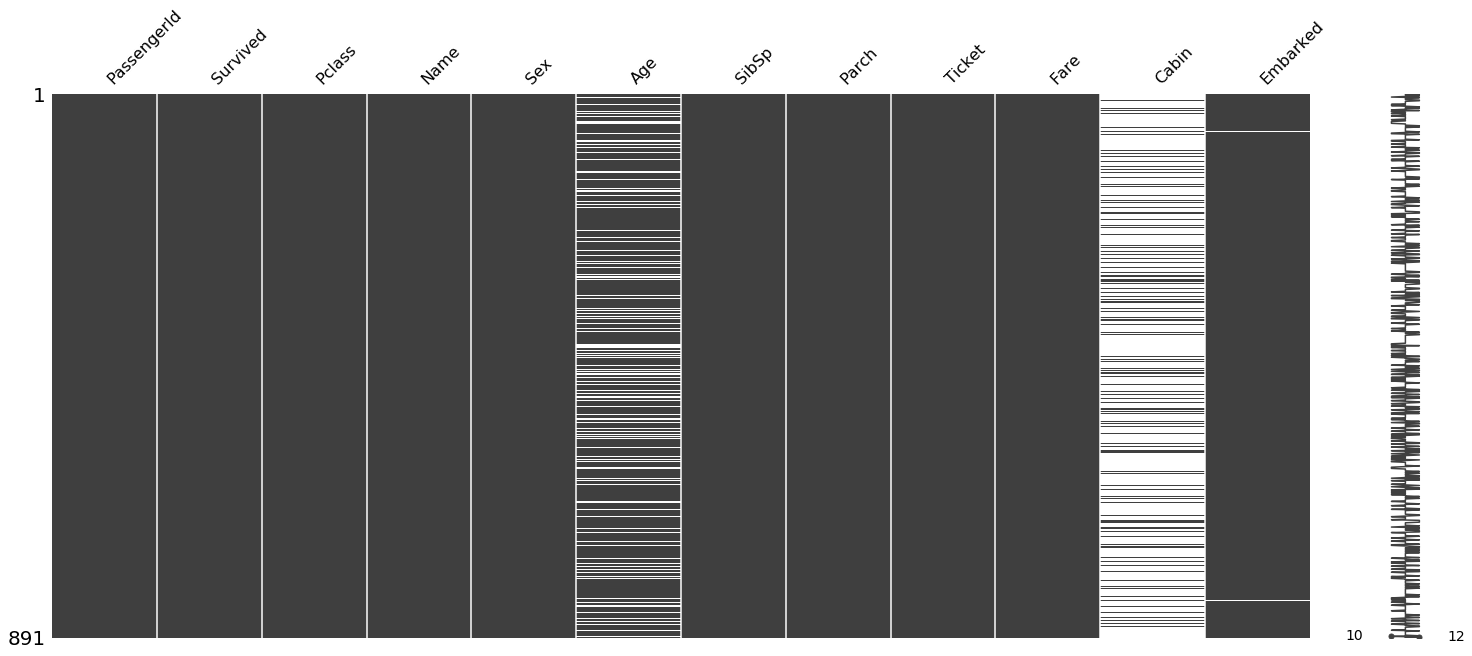

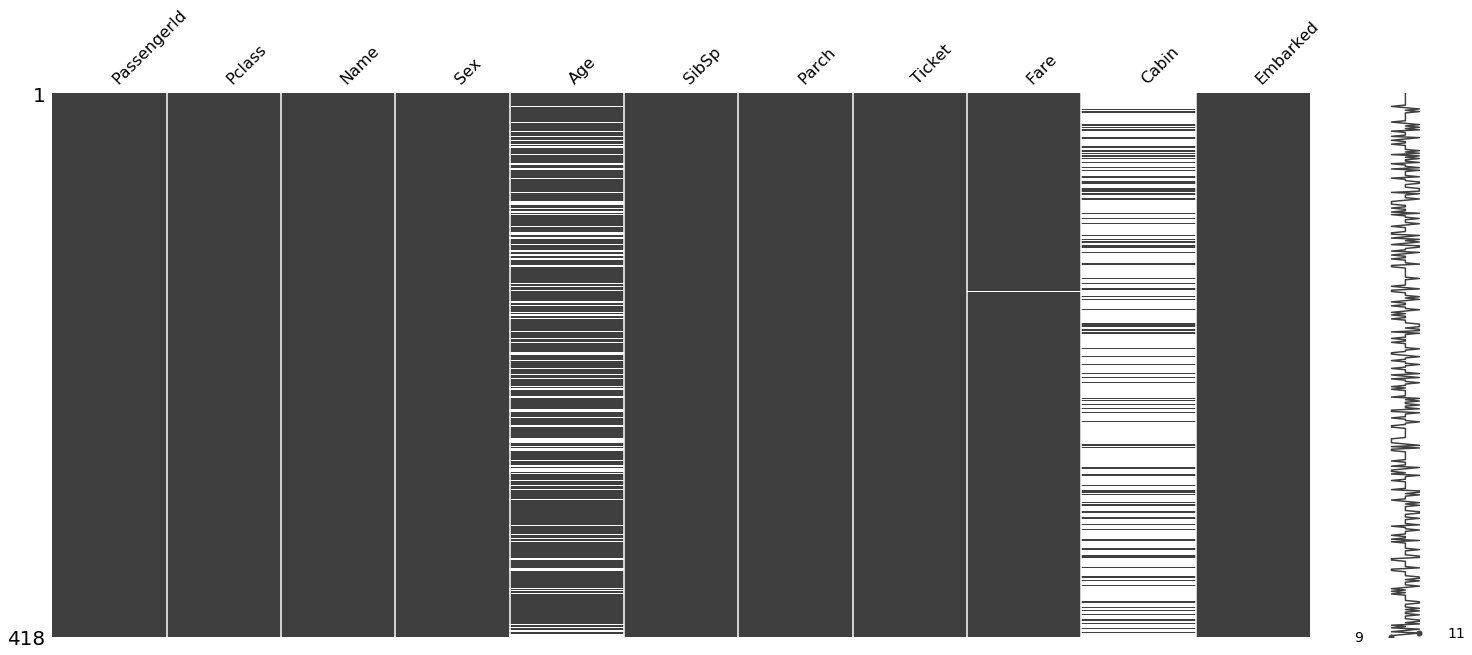

In [6]:
import missingno as msno
msno.matrix(train_df)
msno.matrix(test_df)

In [7]:
# Getting the null values as a percentage
def get_missing_percentages():
    '''
        Gets the missing column row percentages for both datasets and prints it on screen.
    '''
    null_columns_train = train_df.columns[train_df.isnull().any()]
    null_columns_test = test_df.columns[test_df.isnull().any()]
    train_df_missing = train_df[null_columns_train].isnull().sum() / train_df.shape[0]*100
    test_df_missing = test_df[null_columns_test].isnull().sum() / test_df.shape[0]*100

    print(train_df_missing)
    print(test_df_missing)

In [8]:
get_missing_percentages()

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64
Age      20.574163
Fare      0.239234
Cabin    78.229665
dtype: float64


The train dataset has missing values for Age (~20%), Cabin (77%) and Embarked (0.22), while the test dataset also lacks entries in Age(~21%), Fare(0.23%) and Cabin(78%).

This means that for Age and Cabin we could deal with them in the same manner, while Embarked and Fare need to be dealt with separately.

#### 2.1. Dealing with age
The rationale is that we assign the mean age for each class to the missing value, since the mean ages for each classes go down with class, hence the survivability. In addition since age is represented as an integer in the datasets we need to round this numbers to actually make sense.

In [9]:
def fix_missing_age(df):
    '''
        Fixes the missing entries in the age column, bty finding the mean age for each travel class,
        and replaces the missing value with that rounded age.
    '''
    mean_age_dict = {}
    # calculate the mean age for each class
    for pclass in range(1,4):
        mean_age_dict['pclass_mean_age_' + str(pclass)] = np.around(df[df['Pclass'] == pclass]['Age'].mean())
        
    # Asign each class mean age to the seperate class
    for pclass in range(1, 4):
        df.loc[(df['Age'].isna()) & (df['Pclass'] == pclass), 'Age'] = mean_age_dict['pclass_mean_age_' + str(pclass)]
        
    
    return df

In [10]:
train_df = fix_missing_age(train_df)
test_df = fix_missing_age(test_df)

In [11]:
# Quick check (trust, but verify)
get_missing_percentages()

Cabin       77.104377
Embarked     0.224467
dtype: float64
Fare      0.239234
Cabin    78.229665
dtype: float64


#### 2.3. Dealing with Cabin
A simple way to deal with the missing Cabin is that if there is a Cabin identifier a person has a cabin -> 1, if 'NaN' -> 0.

In [12]:
def add_has_cabin(df):
    '''
        Adds a new column to the dataframe - Has Cabin.
        If a passanger is missing the value of Cabin - 0
        If a passanger has a cabing, the column has a value of 1
    '''
    df['hasCabin'] = 0 # Assign all of the hasCabin to 0
    df.loc[~df['Cabin'].isnull(),'hasCabin'] = 1 # assign 1 to only places where there is a value in the Cabin row
    del df['Cabin']
    return df

In [13]:
train_df = add_has_cabin(train_df)
test_df = add_has_cabin(test_df)

In [14]:
# Quick check (trust, but verify)
get_missing_percentages()

Embarked    0.224467
dtype: float64
Fare    0.239234
dtype: float64


#### 2.3. Dealing with Embarked.
Only for the training set.
It might be innacurate, but since the percentage of missing embarked is so low, let us assign the most common value of the Embarked to the missing values.

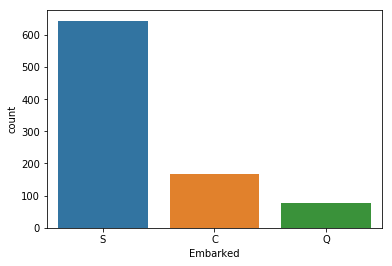

In [15]:
sns.countplot(x="Embarked",  data=train_df)
plt.show()

In [16]:
train_df.loc[train_df['Embarked'].isnull(),'Embarked'] = 'S'

In [17]:
# Quick check (trust, but verify)
get_missing_percentages()

Series([], dtype: float64)
Fare    0.239234
dtype: float64


#### 2.4. Dealing with Fare.

As a first, lets see how many rows are actually missing.

In [18]:
null_columns_test = test_df.columns[test_df.isnull().any()]
test_df_missing = test_df[null_columns_test].isnull().sum()
test_df_missing

Fare    1
dtype: int64

Only 1 item is missing. We can safely drop this row.

In [19]:
test_df = test_df[~test_df['Fare'].isna()]

In [20]:
# Quick check (trust, but verify)
get_missing_percentages()

Series([], dtype: float64)
Series([], dtype: float64)


### 3. Feature Engineering.
The plan is to first go through each feature to see what is their relation to the outcome and determine what new features we can create that will aid is in the prediction.

#### Pclass vs Survived

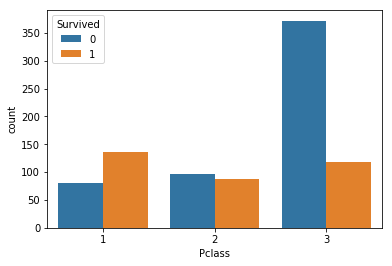

In [21]:
sns.countplot(x="Pclass", hue="Survived", data=train_df)
plt.show()

As expected the people in the third class had the highest mortallity rate.

#### Sex vs Survived

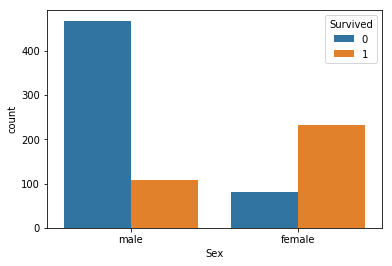

In [22]:
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.show()

Again, nothing surprising, as probably in the rescue operation women and children are with priority. Let's encode the labels before we can proceed.

In [38]:
from sklearn.preprocessing import LabelEncoder
sex_encoder = LabelEncoder()
sex_encoder.fit(train_df['Sex'])

train_df['Sex_enc'] = sex_encoder.transform(train_df['Sex'])
test_df['Sex_enc'] = sex_encoder.transform(test_df['Sex'])

#### Age vs Survived
Here is an interesting one - since age is a continious variable, a more understandable approach would be to split them into age categories. Let the categories be by tens. One could argue that there is a more optimal variant of the split, but this is just a general split and the idea is to split them into groups to distinguish children, teenagers, young adults and so on.

In [50]:
def add_age_class(df):
    df['AgeClass'] = pd.cut(df['Age'], 8, labels=[1,2,3,4,5,6,7,8]).astype('int64')
    return df

In [51]:
train_df = add_age_class(train_df)
test_df = add_age_class(test_df)

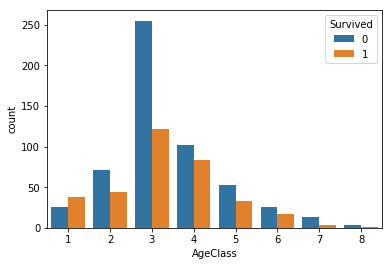

In [52]:
sns.countplot(x="AgeClass", hue="Survived", data=train_df)
plt.show()

The results are not really suprising, but you can clearly see that if you are between the ages of 30 and 40, your chances are not good. In addition let's see the distribution of the Age by itself.

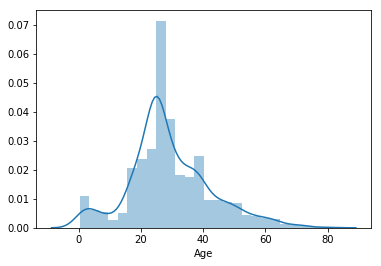

In [33]:
sns.distplot(train_df['Age'])
plt.show()

We see that it skewed to the right. We can deal with this if we scale the feature.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df['AgeScaled'] = scaler.fit_transform(np.array(train_df['Age']).reshape(-1, 1))
test_df['AgeScaled'] = scaler.fit_transform(np.array(test_df['Age']).reshape(-1, 1))

#### Family Size and Survival
Since the data set lists the number of the siblings and parents, we can combine it into a super-feature **FamilySize** that has the total amount of people related to the person.

In [27]:
def add_family_size(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

In [28]:
train_df = add_family_size(train_df)
test_df = add_family_size(test_df)

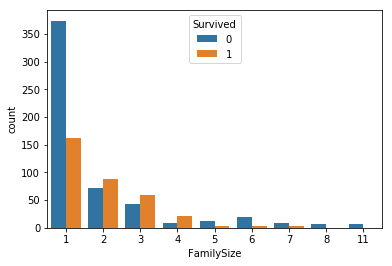

In [29]:
sns.countplot(x="FamilySize", hue="Survived", data=train_df)
plt.show()

It seems that being alone does not amount to much. Let's create another flag, which will tell us if a person is alone or not.

In [30]:
# 0 - person is not alone, 1 is alone
def add_is_alone(df):
    df['isAlone'] = np.where(df['FamilySize'] > 1, 0, 1)
    return df

In [31]:
train_df = add_is_alone(train_df)
test_df = add_is_alone(test_df)

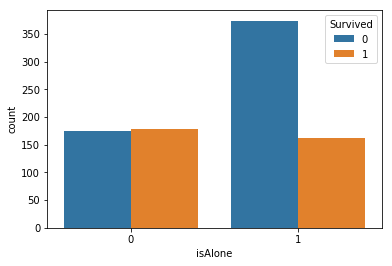

In [32]:
sns.countplot(x="isAlone", hue="Survived", data=train_df)
plt.show()

People with family members on board are more likely to survive, since probably they help each other, while the people that are alone have to fend for themselves.

#### Fare

Since Fare is a continous variable, we can actually look at the distribution to see what kind of shape we are working with.

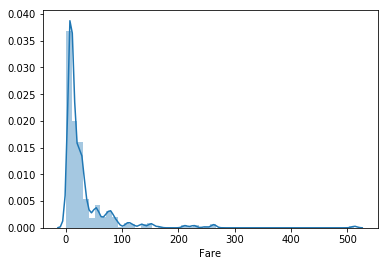

In [21]:
sns.distplot(train_df['Fare'])
plt.show()

Looking at the fare distribution suggest we have a good number of outliers to the right of the median fare. 
Since some models underperform, when outlires are introduced, lets scale the feature.

In [36]:
# We already have the scaler defined earlier
train_df['FareScaled'] = scaler.fit_transform(np.array(train_df['Fare']).reshape(-1, 1))
test_df['FareScaled'] = scaler.fit_transform(np.array(test_df['Fare']).reshape(-1, 1))

#### Embarked vs Survival

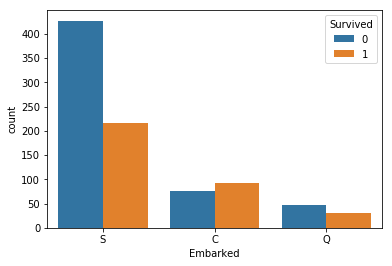

In [24]:
sns.countplot(x="Embarked", hue="Survived", data=train_df)
plt.show()

The relationship between the embark location and survival is probably related to the fact that different classes boarded from different places. Let's encode this feature as well.

In [40]:
embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df['Embarked'])

train_df['Embarked_enc'] = embarked_encoder.transform(train_df['Embarked'])
test_df['Embarked_enc'] = embarked_encoder.transform(test_df['Embarked'])

#### hasCabin vs Survived

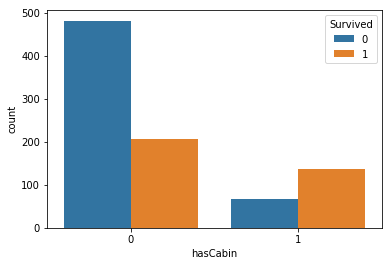

In [25]:
sns.countplot(x="hasCabin", hue="Survived", data=train_df)
plt.show()

It seems people with a cabin have a higher chance of survival, that the people without.

#### Name vs Survived
Placeholder - try to get the title of each person to predict whether poeple with a title have a higher/lower percent of survival f.e. Doctors may rush to help people with health problems, spouses may help each other and so on.

#### Fare vs Age
I am curious whether there is an obvious relationship between Age and Fare - f.e. older people tend to be higher class and pay more, thus their survival option may be increased. Let's explore

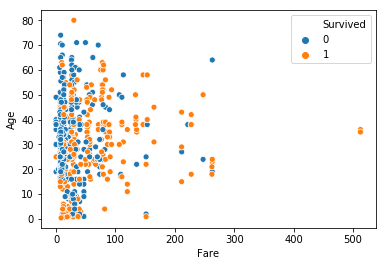

In [47]:
sns.scatterplot(x='Fare', y='Age', data=train_df, hue='Survived')
plt.show()

There is a clear relationship - the more you pay the higher your chances of survival are, but there is certainly some nuance to the relationship - children tend to survive even if they payed laes, while passengers above 20s' survival depend in some way to the fair payed. 

### 4. Model Building, Optimization and Prediction.

My plan is to explore how different models perform and to get the best one to make our submission. In the model choice we can tune it via GridSearch to find the best parameters.

In [90]:
# importing models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# import scoring
from sklearn.metrics import make_scorer, accuracy_score 
# import optimizer
from sklearn.model_selection import GridSearchCV
# import split
from sklearn.model_selection import train_test_split

#### Train, Validation Split

In [54]:
# first clean the dfs from the unnecessary columns
X_train = train_df.drop(labels=['PassengerId', 'Survived', 'Name', 'Sex', 'Ticket', 'Embarked'], axis=1)
y_train = train_df['Survived']
X_test = test_df.drop(labels=['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], axis=1)

In [56]:
# create the training-validation datasets
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, 
                                                                      test_size=0.2, random_state=42)

#### Model Executor
A class that will handle the fitting of the training data and score it agains the validation set.
Then we can use the class for a specific model to predict for the model of choice.

In [78]:
class ModelExecuter:
    def __init__ (self, models, train_x, train_y, valid_x, valid_y):
        self.models = models
        self.train_x = train_x
        self.train_y = train_y
        self.valid_x = valid_x
        self.valid_y = valid_y

    def _fit_all(self):
        for model in self.models:
            model.fit(self.train_x, self.train_y)
        return self
    
    def get_score_all(self):
        self._fit_all()
        for model in self.models:
            model_y_predicted = model.predict(self.valid_x)
            print('{}: {}'.format(type(model).__name__, accuracy_score(self.valid_y, model_y_predicted)))
            
    def predict_specific(self, model_name, testx=None):
        testx = testx if testx is not None else self.test_x
        
        for model in models:
            if type(model).__name__ == model_name:
                clf = model.fit(self.train_x, self.train_y)
                return clf.predict(testx)

#### Model Parameter Estimator
The goal of the parameter estimator is to get the best parameters for our models.

In [60]:
class ModelParamEstimator:
    def __init__ (self, models, model_params_dict, X, y):
        self.models = models
        self.model_params_dict = model_params_dict
        self.X = X
        self.y = y
        
    def evaluate_params (self, nfolds=5):
        best_params = {}
        
        for model in self.models:
            # Check if model in param_grid
            if type(model).__name__ not in self.model_params_dict.keys():
                continue
            # Get the param grid    
            param_grid = self.model_params_dict[type(model).__name__]
            grid_search = GridSearchCV(model, param_grid, cv=nfolds)
            grid_search.fit(self.X, self.y)
            best_params[type(model).__name__] = grid_search.best_params_
        
        return best_params

#### Defining the models to evaluate and optimizing them

In [91]:
models_to_eval = [
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    LogisticRegression(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    XGBClassifier()
]

In [92]:
models_param_grid_dict = {
        'SVC': {'kernel':['rbf', 'linear'], 'probability': [True, False], 'verbose': [True, False]},
        'AdaBoostClassifier': {'n_estimators':[100, 500, 1000, 2000, 3000], 'learning_rate':[0.01, 0.05, 0.1, 1]},
        'RandomForestClassifier': {'n_estimators':[100, 500, 1000, 2000, 3000], 'max_depth':[1,2,3,4,5,6]},
        'KNeighborsClassifier': {'n_neighbors':[2,3,4,5,10, 15, 20]},
        'XGBClassifier': {'n_estimators': range(50, 501, 10), 'max_depth': range(2, 15), 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}
}

In [93]:
# Finding the best parameters
param_estimator = ModelParamEstimator(models_to_eval, models_param_grid_dict, X_training, y_training)
best_params = param_estimator.evaluate_params()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [94]:
best_params

{'AdaBoostClassifier': {'learning_rate': 0.01, 'n_estimators': 1000},
 'KNeighborsClassifier': {'n_neighbors': 3},
 'RandomForestClassifier': {'max_depth': 6, 'n_estimators': 1000},
 'SVC': {'kernel': 'linear', 'probability': True, 'verbose': True},
 'XGBClassifier': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 380}}

#### Evaluating the models

In [95]:
models = [
    SVC(random_state=42, kernel='linear', probability=True, verbose=True),
    RandomForestClassifier(max_depth=6, n_estimators=1000, random_state=42),
    AdaBoostClassifier(learning_rate=0.01, n_estimators=1000, random_state=42),
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=3),
    GaussianNB(),
    DecisionTreeClassifier(),
    XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=380)
]

In [96]:
classifiers = ModelExecuter(models, X_training, y_training, X_validation, y_validation)

In [97]:
classifiers.get_score_all()

[LibSVM]SVC: 0.7877094972067039
RandomForestClassifier: 0.8044692737430168
AdaBoostClassifier: 0.7988826815642458
LogisticRegression: 0.8100558659217877
KNeighborsClassifier: 0.7318435754189944
GaussianNB: 0.7541899441340782
DecisionTreeClassifier: 0.770949720670391
XGBClassifier: 0.8212290502793296


It is clear that the XGBClassifier is achieving the best results.

#### Generating the predictions

In [98]:
predictions = classifiers.predict_specific('XGBClassifier', X_test)

In [99]:
predictions_df = pd.DataFrame({'PassengerId':test_df['PassengerId'].values, 'Survived': predictions})

In [101]:
predictions_df.to_csv('./submissions/titanic_pred__20190113_submission_6.csv')